So I could choose to use the inbuilt `compile` method. Alternatively I could pursue my own fun and form of quaility.

In [81]:
from h5py import File
from os import getcwd

from numpy import array, diag, transpose, zeros, arange, vstack   # Array manipulation 
from numpy import log, sum, exp, sin, pi, mod, floor, mean   # Mathematical operations
from numpy import float32 # Types
from numpy import vectorize

from numpy.linalg import solve  # For the equilibriation

from matplotlib.pyplot import plot

from functools import partial
from itertools import compress, groupby, tee

In [46]:
UNIT_FACTOR = 14.003242 / 6.022 * 5.11 * 31536. / 1.e5
PRODUCTION_RATE = 1.76

In [47]:
model = File(f"{getcwd()}/models/Guttler14.hd5")
model = {key: array([*value]) for key, value in model.items()}

In [48]:
decay = diag([log(2) / 5730] * len(model["fluxes"]))
fluxes = model["fluxes"] / transpose(model["reservoir content"])
balance = diag(sum(fluxes, axis=1))
transfer = transpose(fluxes) - balance - decay
projection = model["production coefficients"]
steady_state = solve(transfer, - projection * PRODUCTION_RATE)

In [50]:
def production(t, *args, steady_state=PRODUCTION_RATE):
    start, duration, phase, area = args

    middle = start + duration / 2.
    height = area / duration
    gaussian = height * exp(- ((t - middle) / (duration / 2)) ** 16.)
    sinusoid = 0.18 * steady_state * sin(2 * pi / 11 * t + phase)
    production = gaussian + sinusoid + steady_state
    
    return UNIT_FACTOR * production

In [51]:
def dydx(y, t, *args):
    return transfer @ y + production(t, *args) * projection

In [52]:
def odeint_linear(y0, derivative, timesteps, parameters=()):
    step_size = timesteps[1] - timesteps[0]
    output = zeros((y0.shape[0], timesteps.shape[0]))
    output[:, 0] = y0
    for j, step in enumerate(timesteps[:-1]):
        output[:, j+1] = output[:, j] + step_size * \
            derivative(output[:, j], step, *parameters)
    return output 

In [39]:
growth_season = [False, False, False, True, True, True, True, True, True, False, False, False]
time_out = 754.4567

In [25]:
def bin_data(carbon_14, time_out, growth_season):
    
    carbon_14 = groupby(zip(floor(time_out), time_out, transpose(test))), lambda x: x[0])
    
    @partial(growth_season=growth_season)
    def in_growth_season(time, growth_season):
        month = int(floor((time - floor(time)) * 12))
        return growth_season[month]

    mask = map(in_growth_season, time_out)
    compress(carbon_14, mask)
    return mask

In [116]:
def in_growth_season(time, growth_season=None):
    month = int(floor((time - floor(time)) * 12))
    return growth_season[month]

in_growth_season = partial(in_growth_season, growth_season=growth_season)

test = transpose(test)
mask = map(in_growth_season, time_out)
c14_mask, time_mask = tee(mask)
other_test = compress(test, mask)
other_time = compress(time_out, time_mask)

# carbon_14 = groupby(zip(floor(time_out), other_test), lambda x: x[0])

# hi = list(map(lambda x: x[1], carbon_14))

In [117]:
list(other_test)

[array([3.44517995e+01, 1.77642041e+02, 2.97736879e+02, 9.92439414e-01,
        1.12822689e+04, 3.88880402e+01, 1.58480785e+02, 1.05862929e+02,
        4.51789314e+02, 1.66375023e+02, 1.83592970e+03]),
 array([3.46762161e+01, 1.77775977e+02, 2.97741195e+02, 9.92449873e-01,
        1.12822689e+04, 3.88955482e+01, 1.58480890e+02, 1.05863208e+02,
        4.51789314e+02, 1.66375023e+02, 1.83592970e+03]),
 array([3.48890852e+01, 1.77915306e+02, 2.97747074e+02, 9.92465572e-01,
        1.12822690e+04, 3.89053426e+01, 1.58481097e+02, 1.05863755e+02,
        4.51789314e+02, 1.66375023e+02, 1.83592970e+03]),
 array([3.50913047e+01, 1.78059453e+02, 2.97754560e+02, 9.92486464e-01,
        1.12822690e+04, 3.89173078e+01, 1.58481437e+02, 1.05864649e+02,
        4.51789315e+02, 1.66375023e+02, 1.83592970e+03]),
 array([3.52837250e+01, 1.78207915e+02, 2.97763695e+02, 9.92512774e-01,
        1.12822691e+04, 3.89313275e+01, 1.58481939e+02, 1.05865963e+02,
        4.51789317e+02, 1.66375024e+02, 1.835929

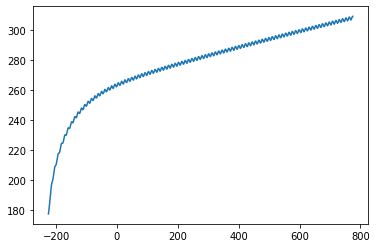

In [109]:
time_out = arange(-225, 775, 0.1)
test = odeint_linear(steady_state, dydx, time_out, parameters=(774.86, 0.25, 0.8, 6.44))
plot(time_out, test[1, :])

In [ ]:
from ticktack import load_presaved_model
from ticktack.fitting import SingleFitter

In [ ]:
carbon_box_model = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
fitting_object = SingleFitter(carbon_box_model)
fitting_object.prepare_function(model="simple_sinusoid")
fitting_object.load_data(f"{getcwd()}/datasets/775AD/NH/Miyake12_Cedar.csv")
fitting_object.dc14_fine((774.86, 0.25, 0.8, 6.44))

DeviceArray([-16.23879236, -16.2310565 , -16.22331509, ..., -13.40276013,
             -13.41207219, -13.42138503], dtype=float64)